In [274]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import numpy as np
import math
import matplotlib.pyplot as plt

In [178]:
transform = transforms.ToTensor()

In [179]:
batch_size = 128

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [103]:
train_it = iter(train_loader)
samples, labels = train_it.next()
samples.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

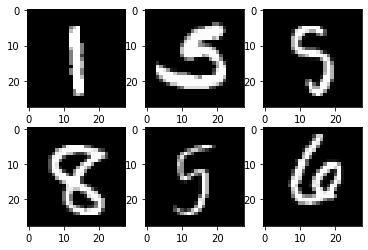

In [104]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [180]:
class CNN_Module(nn.Module):
    def __init__(self, in_channels, emb_dims):
        super().__init__()
        self.out_channels = emb_dims
        
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1) #1x28x28 -> MP 2x2
        self.mp1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) #32x14x14
        self.mp2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, self.out_channels, kernel_size=3, padding=1) #64x7x7
        self.av1 = nn.AvgPool2d((7,7))
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = F.relu(self.conv3(x))
        x = self.av1(x)
        x = x.reshape(-1,self.out_channels)
        return x

In [181]:
cnn = CNN_Module(in_channels=1, emb_dims=64)
cnn(samples).shape

torch.Size([128, 64])

In [182]:
class GCN_Layer(nn.Module):
    def __init__(self, in_dims, out_dims):
        super().__init__()

        self.lin = nn.Linear(in_dims, out_dims)
        
    def forward(self, adjacency_mat, feature_mat):
        x = adjacency_mat @ feature_mat #N, in_dims
        x = F.leaky_relu(self.lin(x))
        return x

In [230]:
gcn = GCN_Layer(64,128)

adj = torch.randn(16, 16)
features = torch.randn(16,64)

gcn(adj,features).shape

torch.Size([16, 128])

In [259]:
class TGCN(nn.Module):
    def __init__(self, in_channels, emb_dims, in_dims, out_dims, num_classes):
        super().__init__()
        
        self.in_channels = in_channels
        self.emb_dims = emb_dims
        self.in_dims = in_dims
        self.out_dims = out_dims
        self.num_classes = num_classes
        
        self.adj_out_dims = 256
        
        self.cnn = CNN_Module(in_channels,emb_dims)
        self.gcn1 = GCN_Layer(in_dims, in_dims)
        self.gcn2 = GCN_Layer(in_dims, out_dims)
        
        self.adjc_fc = nn.Linear(emb_dims, self.adj_out_dims) #En el paper
        self.features_fc = nn.Linear(emb_dims, in_dims)
        
        self.fc1 = nn.Linear(emb_dims+out_dims, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        
        #Loss & Optim
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
    
    def forward(self, x):
        embeddings, out = self.get_gcn_embeddings(x)
        out = torch.cat([embeddings, out], dim=-1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out
    
    def get_gcn_embeddings(self, x):
        embeddings = self.cnn(x)
    
        # Adjacency matrix
        adj_linear = self.adjc_fc(embeddings)
        adjacency_matrix = F.softmax(adj_linear, dim=-1)@(F.softmax(adj_linear,dim=-1).transpose(0,1))
        adjacency_matrix = torch.div(adjacency_matrix,np.sqrt(self.adj_out_dims))
        
        # Feature matrix
        feature_matrix = self.features_fc(embeddings)
        
        #GCN 
        out = F.relu(self.gcn1(adjacency_matrix, feature_matrix))
        out = self.gcn2(adjacency_matrix, out)
        return embeddings, out
    
    def get_final_embeddings(self, x):
        embeddings, out = self.get_gcn_embeddings(x)
        out = cat_tensor = torch.cat([embeddings, out], dim=-1)
        out = F.relu(self.fc1(out))
        return out
    
    def train_step(self, x, y):
        
        logits = self.forward(x)
        
        self.optimizer.zero_grad()
        loss = self.criterion(logits, y)
        loss.backward()
        self.optimizer.step()
        
        return loss.cpu().item()
    
    def get_accuracy(self, x, targets):
        logits = self.forward(x)
        probs = torch.softmax(logits,dim=1)
        predictions = torch.argmax(probs, dim=1)
        return (torch.sum(predictions==targets).item())/float(targets.size()[0])

In [260]:
tcgn = TGCN(1,128,256,512,10)
tcgn(samples).shape

torch.Size([128, 10])

### Train loop

In [277]:
test_samples, test_labels = next(iter(test_loader))
test_samples.shape

torch.Size([128, 1, 28, 28])

In [283]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [284]:
tcgn = TGCN(in_channels=1,emb_dims=128, in_dims=256, out_dims=512,num_classes=10).to(device)

In [285]:
# training loop
num_epochs = 20
n_steps = len(train_loader)

In [286]:
cum_loss = 0
writer = SummaryWriter()

writer.add_graph(tcgn, test_samples.to(device))

for epoch in range(num_epochs):
    for i,(images, labels) in enumerate(train_loader):
        images = images.reshape(-1,1,28,28).to(device)
        labels = labels.to(device)
        
        #forward
        train_loss = tcgn.train_step(images, labels)
        cum_loss += train_loss
        
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_steps}, train loss = {train_loss:.4f}')
            
    with torch.no_grad():
        test_samples = test_samples.to(device)
        gcn_embeddings, _ = tcgn.get_gcn_embeddings(test_samples)
        final_embeddings = tcgn.get_final_embeddings(test_samples)
        
        train_acc = tcgn.get_accuracy(test_samples, test_labels.to(device))
        
        writer.add_scalar('Loss/train',cum_loss/n_steps,epoch)
        writer.add_scalar('Accuracy/test',train_acc,epoch)
        
        writer.add_embedding(gcn_embeddings, metadata=test_labels,label_img=test_samples,global_step=epoch, tag=f"GCN Embeddings")
        writer.add_embedding(final_embeddings, metadata=test_labels,label_img=test_samples,global_step=epoch, tag=f"Final Embeddings")
    
    cum_loss = 0
    
writer.close()

epoch 1 / 20, step 100/469, train loss = 2.0833
epoch 1 / 20, step 200/469, train loss = 1.8191
epoch 1 / 20, step 300/469, train loss = 1.7676
epoch 1 / 20, step 400/469, train loss = 1.4960
epoch 2 / 20, step 100/469, train loss = 1.1143
epoch 2 / 20, step 200/469, train loss = 0.8648
epoch 2 / 20, step 300/469, train loss = 0.8962
epoch 2 / 20, step 400/469, train loss = 0.8629
epoch 3 / 20, step 100/469, train loss = 0.7063
epoch 3 / 20, step 200/469, train loss = 0.5581
epoch 3 / 20, step 300/469, train loss = 0.5935
epoch 3 / 20, step 400/469, train loss = 0.4623
epoch 4 / 20, step 100/469, train loss = 0.6307
epoch 4 / 20, step 200/469, train loss = 0.4535
epoch 4 / 20, step 300/469, train loss = 0.4373
epoch 4 / 20, step 400/469, train loss = 0.4190
epoch 5 / 20, step 100/469, train loss = 0.5174
epoch 5 / 20, step 200/469, train loss = 0.4790
epoch 5 / 20, step 300/469, train loss = 0.4542
epoch 5 / 20, step 400/469, train loss = 0.3029
epoch 6 / 20, step 100/469, train loss =